In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph

In [8]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import scipy.io as spio
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, make_dig_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [9]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [10]:
DATA_PATH = '../Preprocessed_EEG/'

labels = list(scipy.io.loadmat(DATA_PATH + 'label.mat')['label'][0])
labels

[1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

In [11]:
files = list(filter(lambda x: x[0].isnumeric() and x[-4:] == '.mat', os.listdir(DATA_PATH)))
len(files)

45

In [12]:
channel_order = pd.read_excel("../China_information.xlsx", sheet_name='Channel_name_and_order')
my_channels = channel_order['Channel Name']
ch_series = pd.DataFrame({'ch_names' :make_standard_montage('standard_1020').ch_names}).ch_names

montage_dict = dict()
base_dict = make_standard_montage('standard_1020', head_size=0.08).get_positions()['ch_pos']
for ch_name in ch_series[ch_series.isin(my_channels)].values:
    montage_dict[ch_name] = base_dict[ch_name]
montage_dict['CB1'] = base_dict['O1']
montage_dict['CB2'] = base_dict['O2']

seed_montage = make_dig_montage(ch_pos=montage_dict)

In [13]:
def calc_shannon_entropy(data_set):
    """
        Input : 1 * N vector
        Output: Float with the wavelet entropy of the input vector,
                rounded to 3 decimal places.
    """
    probability = np.square(data_set)
    shannon_entropy = -np.nansum(probability * np.log2(probability))
    return round(shannon_entropy, 3)

In [14]:
from scipy.stats import differential_entropy

def get_bands(data, fs=200):
    # data = data[1]
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    res = []
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        res.append(differential_entropy(fft_vals[freq_ix]))

    return res

In [15]:
def get_bands_freq(data, lenght=266, fs=200):
    data = data[1]
    res = []
    for i in range(0, len(data), fs):
        if len(data[i:i+fs]) == fs:
            res.extend(get_bands(data[i:i+fs], fs))
        
    res += [0] * (5 * lenght - len(res))
    return np.array(res)

In [16]:
max_len = 0
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        max_len = max(data_df.shape[1], max_len)

max_len

100%|███████████████████████████████████████████| 45/45 [01:00<00:00,  1.35s/it]


53001

In [17]:
from multiprocessing import cpu_count, Pool

features_tensor = []
targets = []
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        with Pool(cpu_count()) as p:
            sample = np.stack(p.map(get_bands_freq, data_df.iterrows()))
            p.close()
            p.join()
        features_tensor.append(sample)
    targets.extend(labels)

features_tensor = np.stack(features_tensor)
features_tensor = torch.tensor(features_tensor).float()

targets = torch.tensor(targets) + 1
targets = (torch.tensor([0, 1, 2]) == targets.reshape(-1, 1)).int()

100%|███████████████████████████████████████████| 45/45 [13:58<00:00, 18.63s/it]


In [20]:
eloc = make_dig_montage(ch_pos=montage_dict)

In [25]:
frac = round(features_tensor.size(0) * 0.1)

train_A_dataset = CNNMatrixDataset(tensors=(features_tensor[:-frac], targets[:-frac]), with_target=True, transform=None, num_classes=3)
test_A_dataset = CNNMatrixDataset(tensors=(features_tensor[-frac:], targets[-frac:]), with_target=True, transform=None, num_classes=3)

batch_size = 128 #256

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [26]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, count_parameters
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_neighbors_graph

cuda:0
Training complete in 1m 19s
Accuracy:  0.9705882352941176
F1-score:  nan


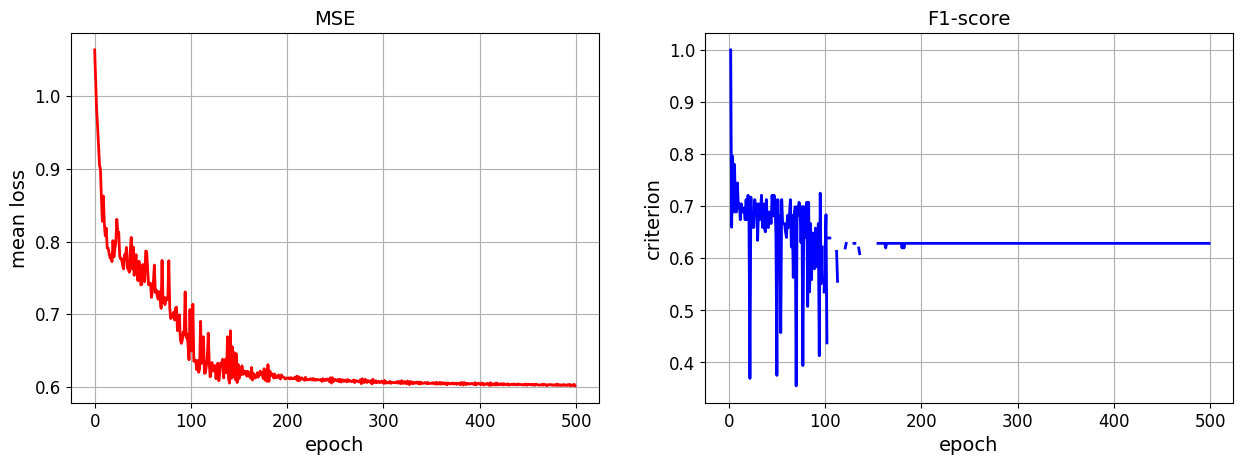

In [27]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = (get_pos_init_graph(eloc) * get_delaunay_graph(eloc)).toarray()
A = torch.tensor(A).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 28s
Accuracy:  0.9705882352941176
F1-score:  nan


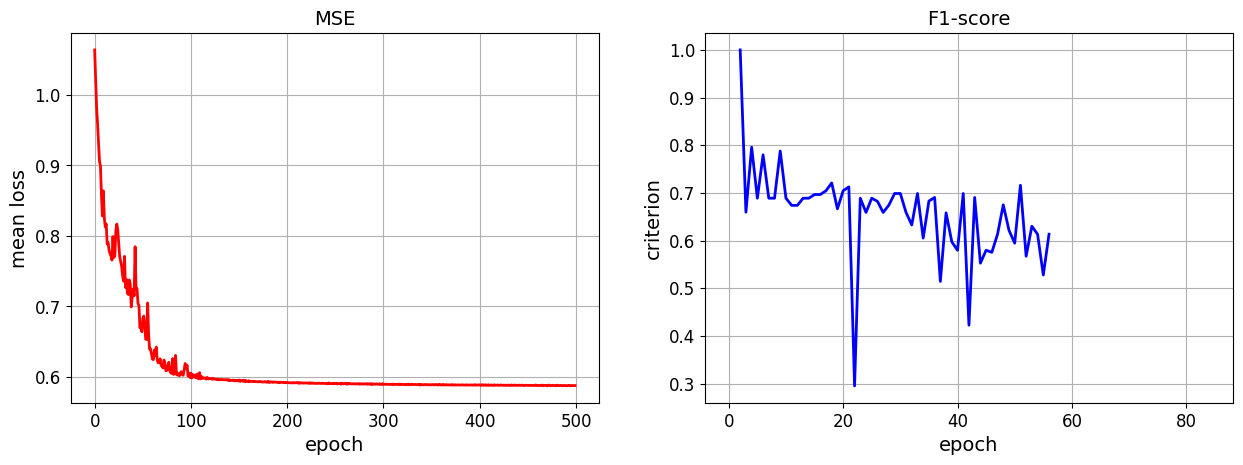

In [28]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = (get_pos_init_graph(eloc) * get_delaunay_graph(eloc)).toarray()
A = torch.tensor(A).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 19s
Accuracy:  0.8823529411764706
F1-score:  nan


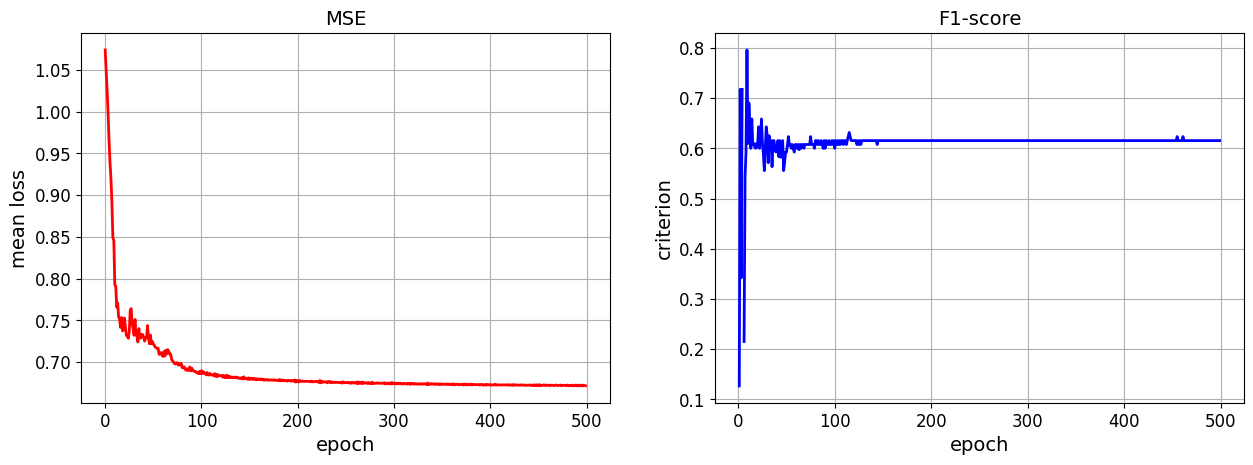

In [30]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.empty(62, 62)
k = math.sqrt(1 / (62 * 62))
nn.init.uniform_(A, -k, k)
A = A.to(my_device).float()
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 28s
Accuracy:  0.9705882352941176
F1-score:  nan


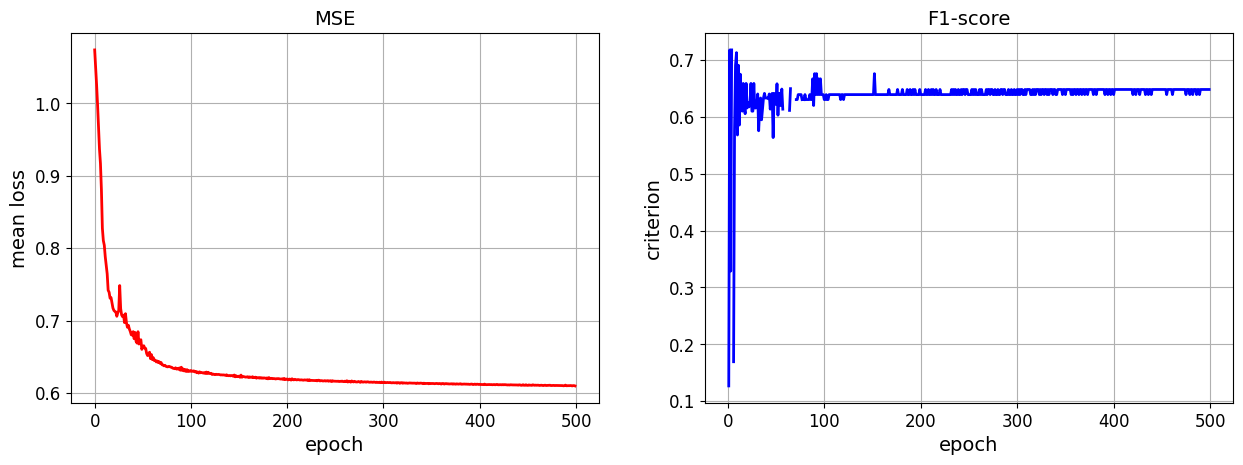

In [31]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.empty(62, 62)
k = math.sqrt(1 / (62 * 62))
nn.init.uniform_(A, -k, k)
A = A.to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 29s
Accuracy:  0.9411764705882353
F1-score:  nan


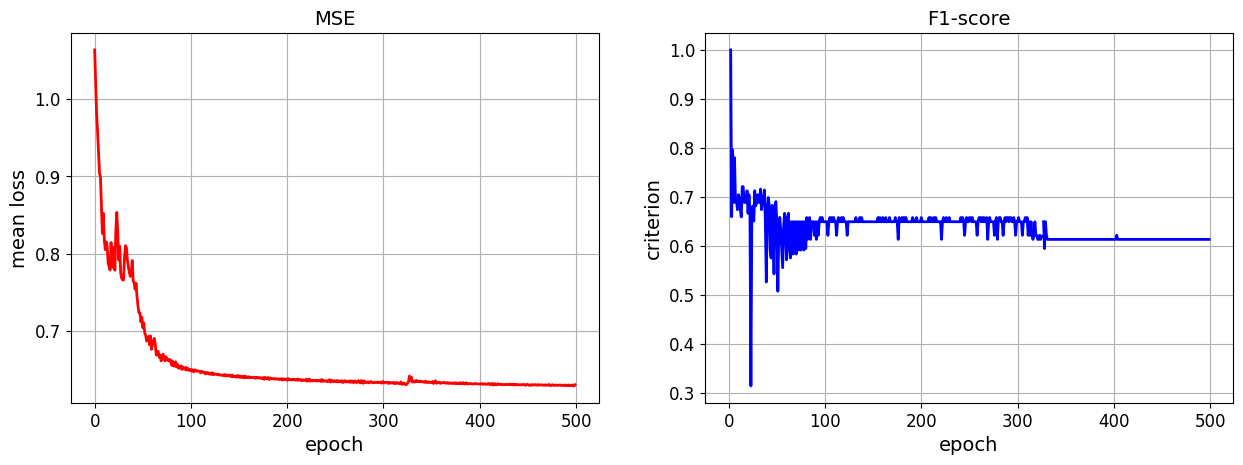

In [32]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = nn.Parameter(data=torch.eye(62, 62).to(my_device).float(), requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 20s
Accuracy:  0.8676470588235294
F1-score:  nan


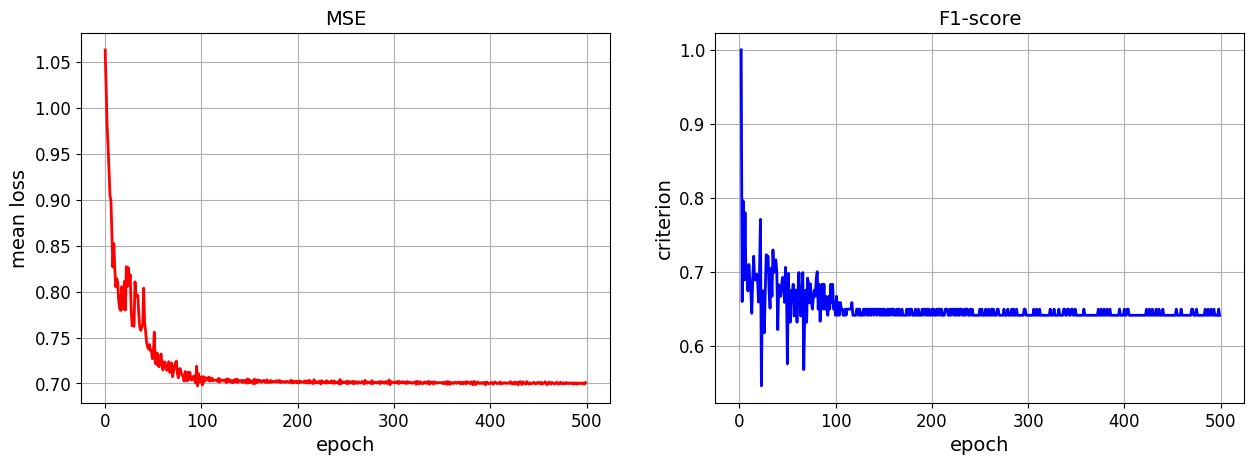

In [33]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.eye(62, 62).to(my_device).float()
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 29s
Accuracy:  0.9705882352941176
F1-score:  nan


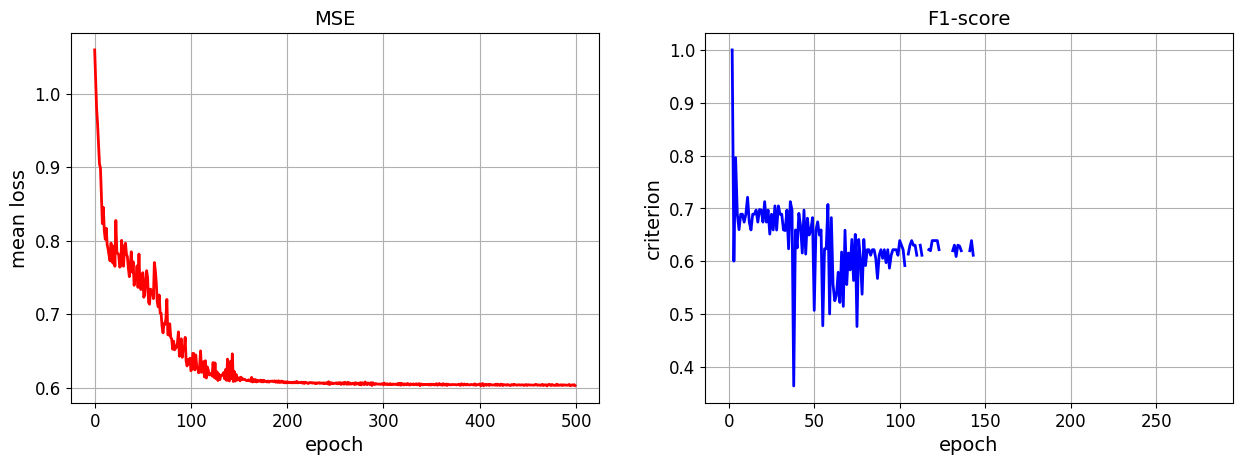

In [34]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.tensor(get_pos_init_graph(eloc)).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 20s
Accuracy:  0.9705882352941176
F1-score:  nan


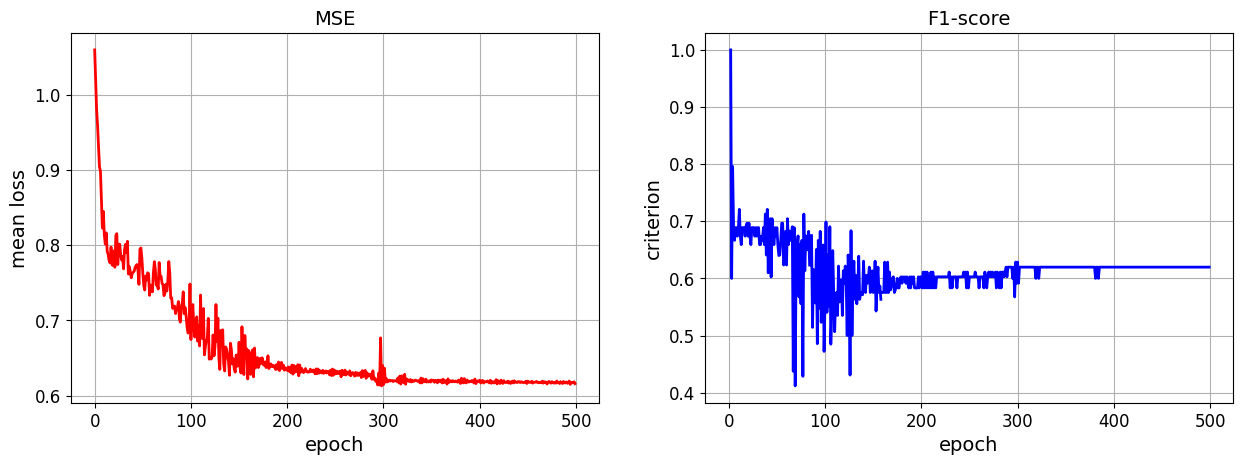

In [35]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.tensor(get_pos_init_graph(eloc)).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 29s
Accuracy:  0.9705882352941176
F1-score:  nan


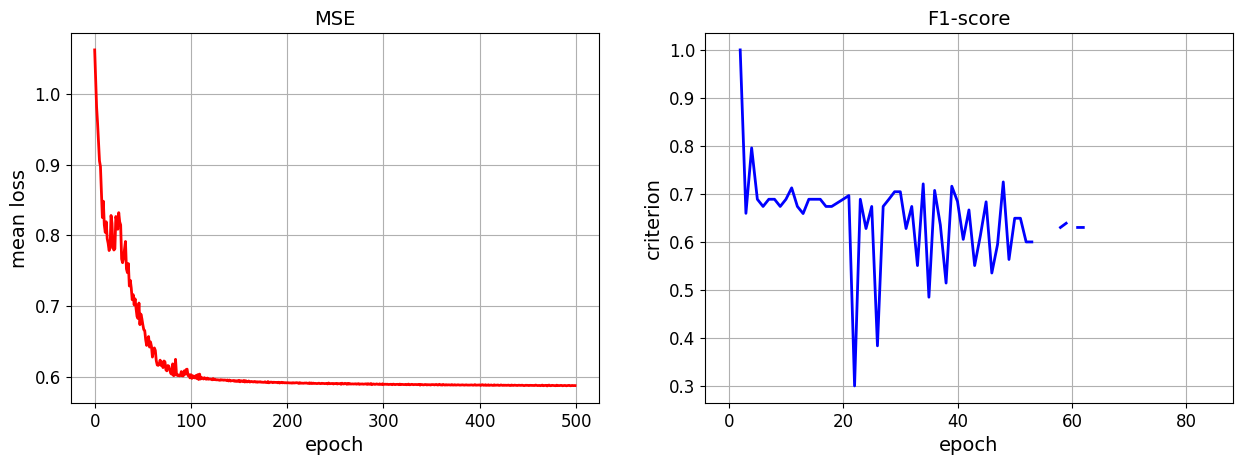

In [36]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

In [37]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'loss', 'Accuracy')

cuda:0
Training complete in 1m 22s
Accuracy:  0.9705882352941176
F1-score:  nan


NameError: name 'loss_cnn' is not defined